# **IMPORT LIBRARY**

In [1]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

In [2]:
# Libraries pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [3]:
# Libraries pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [4]:
# Library Prediksi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# **DATA LOADING**

## Ambil Data Dari Kaggle

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"blehhhh","key":"49e009f7f90a425c9d00a93e4a93f860"}'}

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d pacificrm/skindiseasedataset
!unzip skindiseasedataset.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/phototoxic-reactions-lime-juice-2.jpeg  
  inflating: SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/phototoxic-reactions-lime-juice-3.jpeg  
  inflating: SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-1.jpeg  
  inflating: SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-10.jpeg  
  inflating: SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-100.jpeg  
  inflating: SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-101.jpeg  
  inflating: SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-102.jpeg  
  inflating: SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-103.jpeg  
  inflating: SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-104.jpeg  
  inflating: SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-105.jpeg  
  inflat

# **DATA PREPARATION**

## Membuat Folder

In [10]:
import os
import shutil

In [11]:
!ls SkinDisease/SkinDisease/

test  train


In [12]:
# Direktori awal untuk train dan test
train_dir = "SkinDisease/SkinDisease/train"
test_dir = "SkinDisease/SkinDisease/test"

# Direktori baru untuk dataset gabungan
combined_dir = "SkinDisease/dataset"
os.makedirs(combined_dir, exist_ok=True)

MAX_IMAGES = 2000

In [13]:
def copy_limited_images(source_dir, target_dir, limit=2000):
    os.makedirs(target_dir, exist_ok=True)
    files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]
    for file in files[:limit]:
        shutil.copy2(os.path.join(source_dir, file), os.path.join(target_dir, file))

# Salin maksimal 2000 gambar dari setiap kategori di train
for category in os.listdir(train_dir):
    src = os.path.join(train_dir, category)
    dst = os.path.join(combined_dir, category)
    if os.path.isdir(src):
        copy_limited_images(src, dst, limit=2000)

# Salin maksimal 2000 gambar dari setiap kategori di test
for category in os.listdir(test_dir):
    src = os.path.join(test_dir, category)
    dst = os.path.join(combined_dir, category)
    if os.path.isdir(src):
        copy_limited_images(src, dst, limit=2000)

## Dataset Chengking

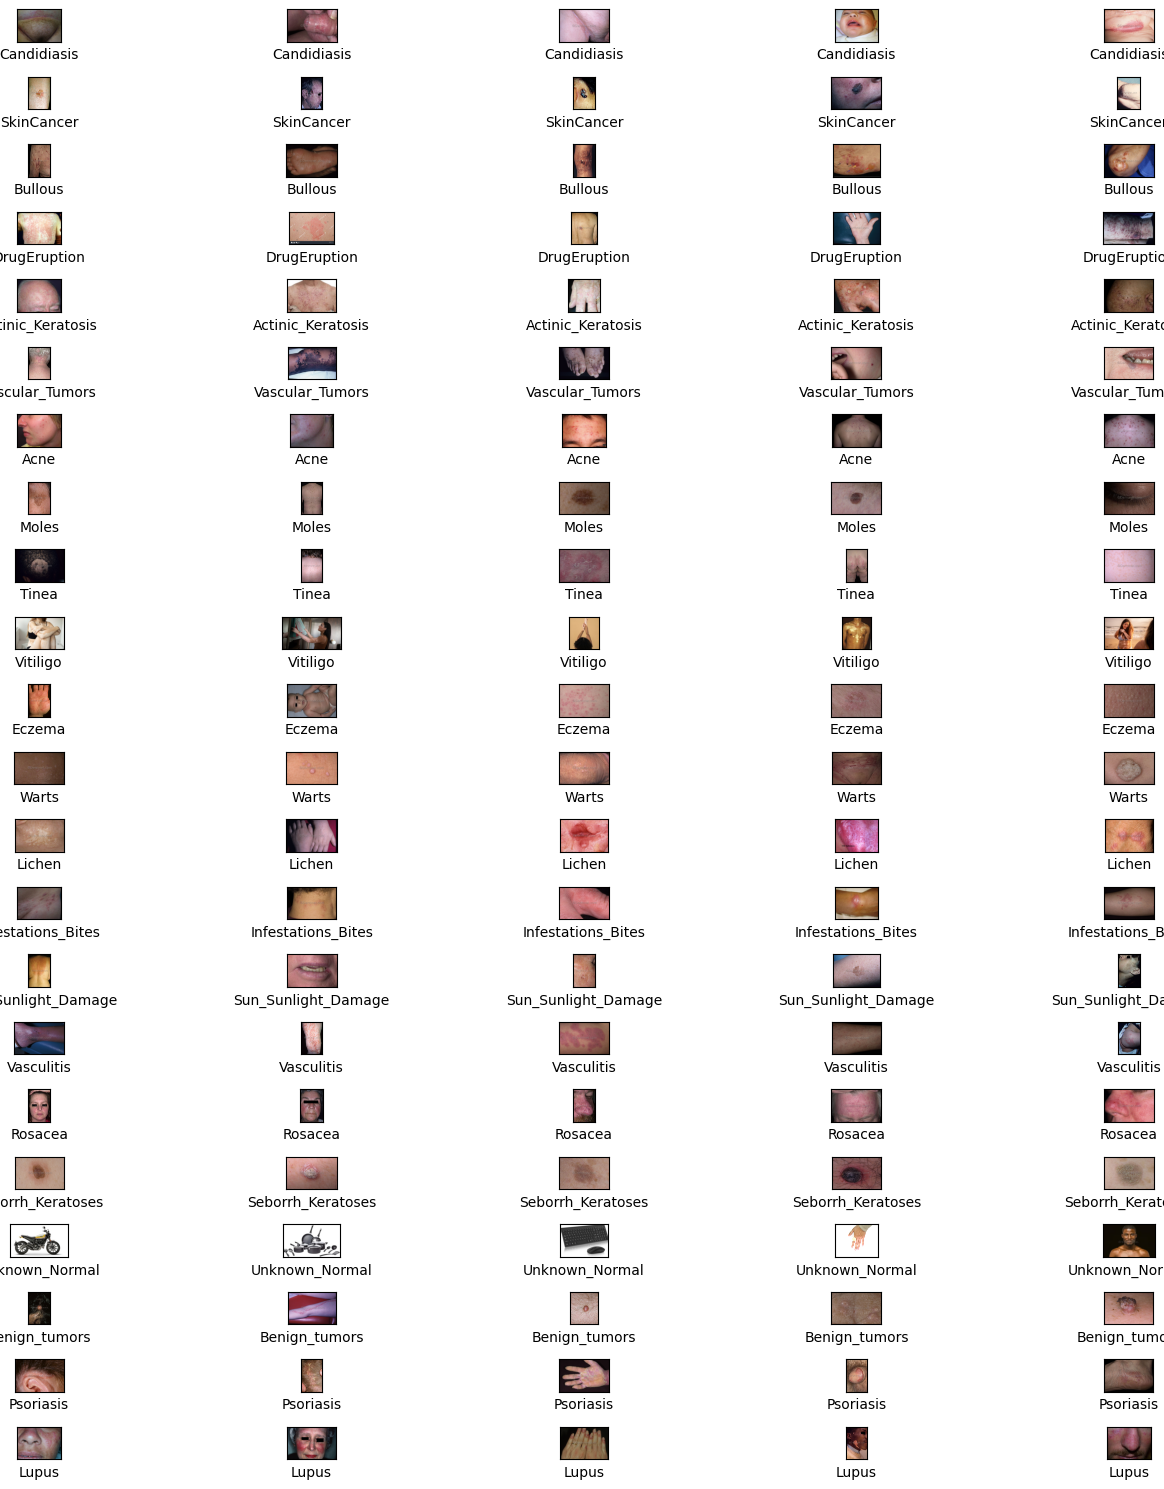

In [14]:
import matplotlib.pyplot as plt
skin_image = {}
path = "SkinDisease/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    skin_image[i] = os.listdir(os.path.join(path_sub, i))

path_sub = "SkinDisease/dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(skin_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(skin_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

## Plot Distribusi

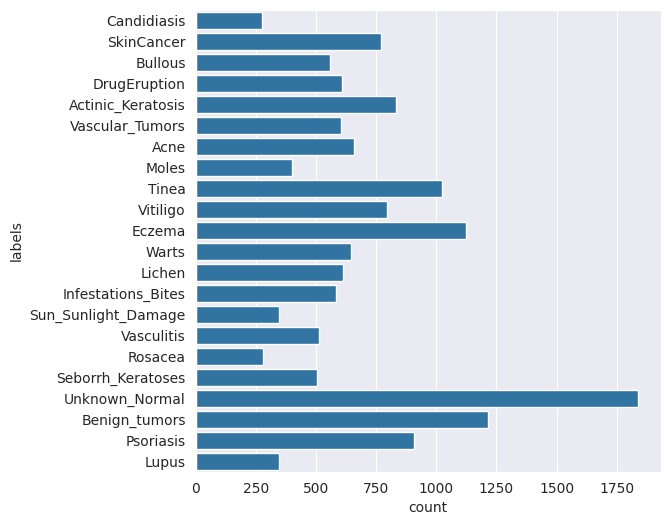

In [15]:
import seaborn as sns

# Definisikan path sumber
skin_path = "SkinDisease/dataset/"

file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(skin_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})


Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

# **DATA AUGMENTATION**

In [16]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = img / 255.0
    angle = random.randint(0,180)
    return rotate(img, angle)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [17]:
import os
import cv2
import numpy as np
from skimage.transform import rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
import random

def augment_image(img):
    augmented_images = []
    augmented_images.append(anticlockwise_rotation(img))
    augmented_images.append(clockwise_rotation(img))
    augmented_images.append(flip_up_down(img))
    augmented_images.append(add_brightness(img))
    augmented_images.append(blur_image(img))
    augmented_images.append(sheared(img))
    augmented_images.append(warp_shift(img))
    return augmented_images

input_folder = "SkinDisease/dataset"
output_folder = "SkinDisease/augmented"
os.makedirs(output_folder, exist_ok=True)

for root, dirs, files in os.walk(input_folder):
    for filename in files:
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(root, filename)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to read {img_path}")
                continue

            augmented_imgs = augment_image(img)

            # Buat folder tujuan dengan struktur yang sama dengan folder input
            relative_path = os.path.relpath(root, input_folder)
            save_dir = os.path.join(output_folder, relative_path)
            os.makedirs(save_dir, exist_ok=True)

            for i, aug_img in enumerate(augmented_imgs):
                if aug_img.max() <= 1.0:
                    aug_img = (aug_img * 255).astype(np.uint8)
                if len(aug_img.shape) == 3 and aug_img.shape[2] == 3:
                    aug_img = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
                save_path = os.path.join(save_dir, f"{os.path.splitext(filename)[0]}_aug{i+1}.png")
                cv2.imwrite(save_path, aug_img)

print("Augmentasi selesai dan tersimpan dengan struktur folder sama.")


Augmentasi selesai dan tersimpan dengan struktur folder sama.


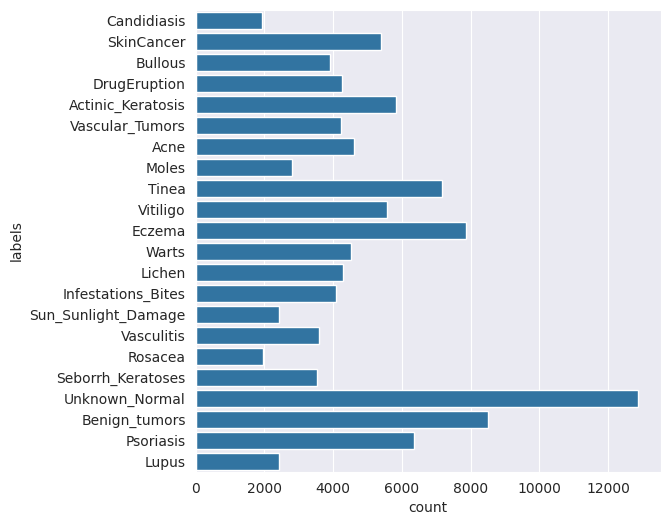

In [18]:
skin_path = "SkinDisease/augmented/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(skin_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

# **DATA SPLITING**

In [19]:
mypath= 'SkinDisease/augmented/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df.groupby(['labels']).size()

,0
labels,
Acne,4606
Actinic_Keratosis,5817
Benign_tumors,8498
Bullous,3913
Candidiasis,1925
DrugEruption,4256
Eczema,7854
Infestations_Bites,4088
Lichen,4298


In [20]:
X= df['path']
y= df['labels']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [21]:
df_tr = pd.DataFrame({
    'path': X_train,
    'file_name': X_train.apply(lambda x: os.path.basename(x)),
    'labels': y_train,
    'set': 'train'
})

df_te = pd.DataFrame({
    'path': X_test,
    'file_name': X_test.apply(lambda x: os.path.basename(x)),
    'labels': y_test,
    'set': 'test'
})

In [22]:
df_tr_limited = (
    df_tr.groupby('labels', group_keys=False)
         .apply(lambda x: x.sample(n=min(2000, len(x)), random_state=42))
         .reset_index(drop=True)
)

<ipython-input-22-19f0827ddf03>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(2000, len(x)), random_state=42))


In [23]:
df_all = pd.concat([df_tr_limited, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset augmented
datasource_path = "SkinDisease/augmented/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels             
test   Acne                    922
       Actinic_Keratosis      1118
       Benign_tumors          1707
       Bullous                 791
       Candidiasis             358
       DrugEruption            858
       Eczema                 1545
       Infestations_Bites      868
       Lichen                  876
       Lupus                   495
       Moles                   568
       Psoriasis              1250
       Rosacea                 399
       Seborrh_Keratoses       769
       SkinCancer             1089
       Sun_Sunlight_Damage     498
       Tinea                  1442
       Unknown_Normal         2544
       Vascular_Tumors         811
       Vasculitis              695
       Vitiligo               1119
       Warts                   900
train  Acne                   2000
       Actinic_Keratosis      2000
       Benign_tumors          2000
       Bullous                2000
       Candidiasis            1567
       DrugEruption        

In [24]:
df_train_cut = (
    df_all[df_all['set'] == 'train']
    .groupby('labels', group_keys=False)
    .apply(lambda x: x.sample(n=min(2000, len(x)), random_state=42))
)

df_all_cut = pd.concat([df_train_cut, df_all[df_all['set'] == 'test']], ignore_index=True)

<ipython-input-24-644d8a2648a2>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(2000, len(x)), random_state=42))


In [25]:
from tqdm import tqdm as tq
import shutil
import os

datasource_path = "SkinDisease/augmented/"
dataset_path = "Dataset-Final/"

for index, row in tq(df_all_cut.iterrows(), total=len(df_all_cut)):
    file_path = row['path']

    if not os.path.exists(file_path):
        file_path = os.path.join(datasource_path, row['labels'], row['file_name'])

    dest_dir = os.path.join(dataset_path, row['set'], row['labels'])
    os.makedirs(dest_dir, exist_ok=True)

    file_dest = os.path.join(dest_dir, os.path.basename(file_path))

    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)

100%|██████████| 64608/64608 [02:07<00:00, 506.82it/s]


# **IMAGE DATA GENERATOR**

In [26]:
import os

TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

print("Jumlah gambar per label (TRAINING SET):")
print("==========================================")
for label in sorted(os.listdir(TRAIN_DIR)):
    label_path = os.path.join(TRAIN_DIR, label)
    if os.path.isdir(label_path):
        count = len(os.listdir(label_path))
        print(f"{label:<25}: {count}")

print("\n Jumlah gambar per label (TEST SET):")
print("======================================")
for label in sorted(os.listdir(TEST_DIR)):
    label_path = os.path.join(TEST_DIR, label)
    if os.path.isdir(label_path):
        count = len(os.listdir(label_path))
        print(f"{label:<25}: {count}")


Jumlah gambar per label (TRAINING SET):
Acne                     : 2000
Actinic_Keratosis        : 2000
Benign_tumors            : 2000
Bullous                  : 2000
Candidiasis              : 1567
DrugEruption             : 2000
Eczema                   : 2000
Infestations_Bites       : 2000
Lichen                   : 2000
Lupus                    : 1920
Moles                    : 2000
Psoriasis                : 2000
Rosacea                  : 1575
Seborrh_Keratoses        : 2000
SkinCancer               : 2000
Sun_Sunlight_Damage      : 1924
Tinea                    : 2000
Unknown_Normal           : 2000
Vascular_Tumors          : 2000
Vasculitis               : 2000
Vitiligo                 : 2000
Warts                    : 2000

 Jumlah gambar per label (TEST SET):
Acne                     : 922
Actinic_Keratosis        : 1118
Benign_tumors            : 1707
Bullous                  : 791
Candidiasis              : 358
DrugEruption             : 858
Eczema                   : 154

In [27]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# TRAINING
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=64,
    target_size=(224, 224),
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# VALIDATION
validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=64,
    target_size=(224, 224),
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# TESTING
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

Found 34390 images belonging to 22 classes.
Found 8596 images belonging to 22 classes.
Found 21622 images belonging to 22 classes.


# **SKEMA TUNING**

## MobileNetV2

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import MobileNetV2


base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

x = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(23, activation='softmax')
])

model = x

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │         5,911 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,597,975 (9.91 MB)

 Trainable params: 336,919 (1.29 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

In [29]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import models
import numpy as np


class_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights = dict(enumerate(class_weights))

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model_skindisease = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(train_generator.num_classes, activation='softmax')
])


model_skindisease.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model_skindisease.h5', save_best_only=True, monitor='val_loss', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, min_lr=1e-6)

history_skindisease = model_skindisease.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.1617 - loss: 2.8577
Epoch 1: val_loss improved from inf to 2.49380, saving model to best_model_skindisease.h5


538/538 ━━━━━━━━━━━━━━━━━━━━ 220s 386ms/step - accuracy: 0.1618 - loss: 2.8572 - val_accuracy: 0.2413 - val_loss: 2.4938 - learning_rate: 5.0000e-04
Epoch 2/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.3192 - loss: 2.2518
Epoch 2: val_loss improved from 2.49380 to 2.41782, saving model to best_model_skindisease.h5


538/538 ━━━━━━━━━━━━━━━━━━━━ 160s 297ms/step - accuracy: 0.3192 - loss: 2.2517 - val_accuracy: 0.2616 - val_loss: 2.4178 - learning_rate: 5.0000e-04
Epoch 3/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.3684 - loss: 2.0732
Epoch 3: val_loss did not improve from 2.41782
538/538 ━━━━━━━━━━━━━━━━━━━━ 149s 278ms/step - accuracy: 0.3684 - loss: 2.0731 - val_accuracy: 0.2711 - val_loss: 2.4234 - learning_rate: 5.0000e-04
Epoch 4/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.3873 - loss: 1.9906
Epoch 4: val_loss did not improve from 2.41782
538/538 ━━━━━━━━━━━━━━━━━━━━ 149s 276ms/step - accuracy: 0.3873 - loss: 1.9906 - val_accuracy: 0.2800 - val_loss: 2.4244 - learning_rate: 5.0000e-04
Epoch 5/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.4084 - loss: 1.9118
Epoch 5: val_loss improved from 2.41782 to 2.41684, saving model to best_model_skindisease.h5


538/538 ━━━━━━━━━━━━━━━━━━━━ 199s 270ms/step - accuracy: 0.4084 - loss: 1.9118 - val_accuracy: 0.2806 - val_loss: 2.4168 - learning_rate: 5.0000e-04
Epoch 6/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.4276 - loss: 1.8534
Epoch 6: val_loss did not improve from 2.41684
538/538 ━━━━━━━━━━━━━━━━━━━━ 146s 272ms/step - accuracy: 0.4276 - loss: 1.8535 - val_accuracy: 0.2786 - val_loss: 2.4451 - learning_rate: 5.0000e-04
Epoch 7/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.4341 - loss: 1.8181
Epoch 7: val_loss improved from 2.41684 to 2.40817, saving model to best_model_skindisease.h5


538/538 ━━━━━━━━━━━━━━━━━━━━ 150s 279ms/step - accuracy: 0.4341 - loss: 1.8181 - val_accuracy: 0.2903 - val_loss: 2.4082 - learning_rate: 5.0000e-04
Epoch 8/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.4409 - loss: 1.7803
Epoch 8: val_loss improved from 2.40817 to 2.40308, saving model to best_model_skindisease.h5


538/538 ━━━━━━━━━━━━━━━━━━━━ 151s 281ms/step - accuracy: 0.4409 - loss: 1.7803 - val_accuracy: 0.2892 - val_loss: 2.4031 - learning_rate: 5.0000e-04
Epoch 9/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.4505 - loss: 1.7570
Epoch 9: val_loss did not improve from 2.40308
538/538 ━━━━━━━━━━━━━━━━━━━━ 161s 299ms/step - accuracy: 0.4505 - loss: 1.7570 - val_accuracy: 0.2808 - val_loss: 2.4413 - learning_rate: 5.0000e-04
Epoch 10/10
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.4551 - loss: 1.7185
Epoch 10: val_loss did not improve from 2.40308
538/538 ━━━━━━━━━━━━━━━━━━━━ 188s 273ms/step - accuracy: 0.4551 - loss: 1.7185 - val_accuracy: 0.2979 - val_loss: 2.4048 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 8.


In [30]:
base_model.trainable = True

fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model_skindisease.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

initial_epochs = 10
fine_tune_epochs = 25
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model_skindisease.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=total_epochs,
    initial_epoch=history_skindisease.epoch[-1],
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1),
        checkpoint
    ],
    class_weight=class_weights,
    verbose=1
)

Epoch 10/35
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.3572 - loss: 2.3041
Epoch 10: val_loss did not improve from 2.40308
538/538 ━━━━━━━━━━━━━━━━━━━━ 199s 328ms/step - accuracy: 0.3574 - loss: 2.3034 - val_accuracy: 0.2503 - val_loss: 3.2438 - learning_rate: 1.0000e-04
Epoch 11/35
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.5313 - loss: 1.4901
Epoch 11: val_loss did not improve from 2.40308
538/538 ━━━━━━━━━━━━━━━━━━━━ 154s 286ms/step - accuracy: 0.5313 - loss: 1.4900 - val_accuracy: 0.2623 - val_loss: 3.1389 - learning_rate: 1.0000e-04
Epoch 12/35
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.6124 - loss: 1.2144
Epoch 12: val_loss did not improve from 2.40308
538/538 ━━━━━━━━━━━━━━━━━━━━ 154s 286ms/step - accuracy: 0.6124 - loss: 1.2144 - val_accuracy: 0.2782 - val_loss: 3.3622 - learning_rate: 1.0000e-04
Epoch 13/35
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.6855 - loss: 0.9761
Epoch 13: val_loss did not improve from 2.40308
538/5

In [31]:
# Evaluasi akurasi pada training set
train_loss, train_acc = model_skindisease.evaluate(train_generator, verbose=0)
print(f"Akurasi Training Set: {train_acc * 100:.2f}%")

# Evaluasi akurasi pada testing set
test_loss, test_acc = model_skindisease.evaluate(test_generator, verbose=0)
print(f"Akurasi Testing Set: {test_acc * 100:.2f}%")

Akurasi Training Set: 92.43%
Akurasi Testing Set: 63.40%


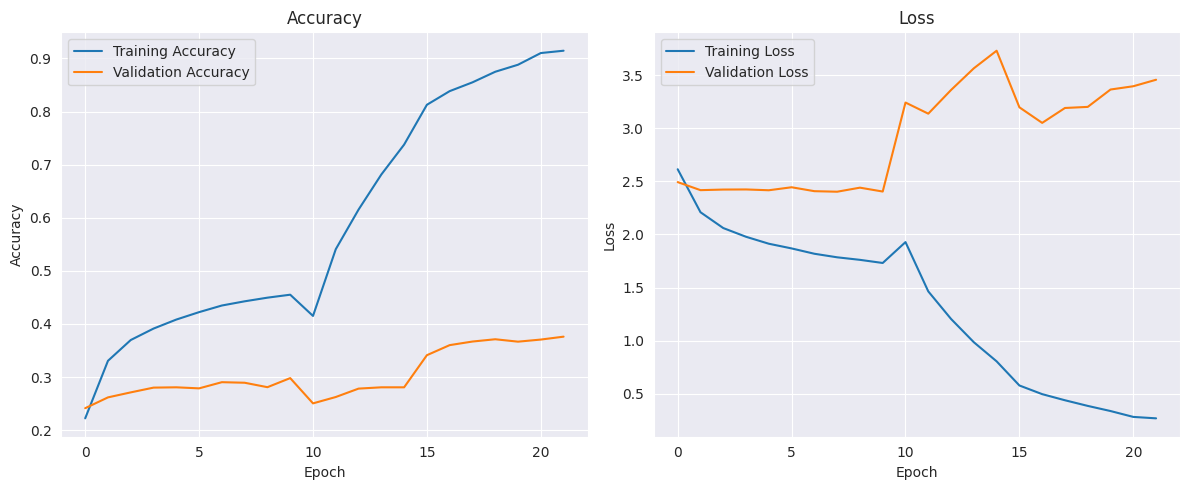

In [32]:
import matplotlib.pyplot as plt

def plot_history(history1, history2=None):
    acc = history1.history['accuracy']
    val_acc = history1.history['val_accuracy']
    loss = history1.history['loss']
    val_loss = history1.history['val_loss']

    if history2:
        acc = acc + history2.history['accuracy']
        val_acc = val_acc + history2.history['val_accuracy']
        loss = loss + history2.history['loss']
        val_loss = val_loss + history2.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_skindisease, history_fine)

In [33]:
model.save('model_skin_disease.h5')

from google.colab import files
files.download('model_skin_disease.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **PREDIKSI**

In [34]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Load model yang sudah dilatih dan disimpan
model = load_model('best_model_skindisease.h5')

In [35]:
class_names = list(train_generator.class_indices.keys())

def predict_skin_disease(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)

    return predicted_class, confidence


In [36]:
img_path = 'contoh_foto.jpg'  # Ganti dengan path gambar input
label, conf = predict_skin_disease(img_path)
print(f"Prediksi: {label} (Confidence: {conf*100:.2f}%)")

FileNotFoundError: [Errno 2] No such file or directory: 'contoh_foto.jpg'

In [ ]:
bbhbhbsnjsnjsnjsnnjnjnjnnnnn